In [1]:
import sys
sys.path.append('./../gp_sinkhorn/')
sys.path.append('./..')
from SDE_solver import solve_sde_RK
from gp_sinkhorn.utils import plot_trajectories_2
from MLE_drift import *

import copy
import torch
import math
import numpy as np

from celluloid import Camera
from IPython.display import HTML
import matplotlib.pyplot as plt
import pickle as pkl
import seaborn as sns
sns.set_style("whitegrid")

In [40]:
mocap = pkl.load(open("./../assets/motion_data.pkl", "rb"))
full_dict, downsampled_dict, key_ = mocap
key_dict = {}
for i in key_:
    if i[0] not in ['29','30']:
        key_dict[i[0]+i[1]] = [i[2],i[3]]
    else:
        print("Remove ",i)

Remove  ['30', '01', 526, 538]
Remove  ['29', '07', 515, 533]
Remove  ['29', '02', 486, 505]


#  Estimating speed boundaries from position only 


The next cell shows you how to obtain the speed timeseries and subsequently speed boundaries given only position time series as inputs which is needed for the MOCAP data. Once obtain position and speed boundaries must be concatenated respectively before feeding to IPFP. Virtually this is all the setup we need + the motion priors illustrated in the earlier part of this notebook.


In [41]:
from scipy.signal import savgol_filter


def estimate_boundary_velocities(X, window=7, poly=5, mode='nearest'):
    n, t, d = X.shape
    
    V = np.zeros((n,t,d))
    
    Xnp = np.array(X)
    
    for i in range(n):
        for dj in range(d):
            V[i, :, dj] = savgol_filter(Xnp[i, :, dj], window, poly, mode=mode, deriv=1, delta=0.01)
    
    return torch.tensor(V).double()


# Vts = estimate_boundary_velocities(Xts[:,:,:dim*particles], window=3, poly=2, mode="interp")

In [42]:
out_mat_pos = []
out_mat_vel = []

P_0 = []
P_1 = []


sensor_no = 2
traj = []
dt = 0.1
N = int(math.ceil(1.0/dt))


for k, v in full_dict.items():
    for k1, v1 in v.items():
        try:
            if k+k1 == '3105':
                raise("Error")
            out_mat_vel.append(
                estimate_boundary_velocities(torch.tensor([v1]), window=5, poly=3, mode="interp")[0]
            )

            out_mat_pos.append(
                torch.tensor([v1])[0]
            )
            start,end = key_dict[k+k1][0],key_dict[k+k1][1]
            traj.append(v1[start:end,:sensor_no])
            print(k,k1)
            P_0.append(torch.cat((out_mat_pos[-1][start][:sensor_no], out_mat_vel[-1][start][:sensor_no])))

            P_1.append(torch.cat((out_mat_pos[-1][end][:sensor_no], out_mat_vel[-1][end][:sensor_no])))
        except:
            print("Key ",k,k1," has been cut")


# out_mat = torch.tensor(out_mat).double?()
# print(P_0)
P_0 = torch.vstack(P_0)
P_1 = torch.vstack(P_1)

P = torch.vstack([P_0,P_1])
P_0 = (P_0-P.mean(axis=0))/P.std(axis=0)
P_1 = (P_1-P.mean(axis=0))/P.std(axis=0)


# This will be used for the plotting later one 
traj = torch.tensor([np.concatenate((i[::int(i.shape[0]/N),:][:(N),:],i[-1,:].reshape((1,-1))),axis=0) for i in traj])
traj = (traj-P.mean(axis=0)[:sensor_no])/P.std(axis=0)[:sensor_no]

40 12
41 10
41 11
26 02
27 02
27 06
28 01
Key  29 02  has been cut
Key  29 07  has been cut
Key  30 01  has been cut
Key  30 07  has been cut
31 01
Key  31 05  has been cut
32 03
32 07


In [43]:
def solve_sde_RK_s(b_drift=None, sigma=None, X0=None, dt=1.0, N=100, t0=0.0,
                 theta=None, noise=False, forwards=True):
    """
            Euler Mayurama method
    Syntax:
    ----------
    solve_sde(b_drift=None, sigma=None, X0=None, dt=None, N=100, t0=0, DW=None)
    Parameters:
    ----------
        b_drift  : Time dependan drift, the X state (with last dimension as time)
                defines the differential equation.
        sigma  : a  constant volatility
        X0    : Initial conditions of the SDE. Mandatory for SDEs
                with variables > 1 (default: gaussian np.random)
        dt    : The timestep of the solution
                (default: 1)
        N     : The number of timesteps (defines the length of the timeseries)
                (default: 100)
        t0    : The initial time of the solution
                (default: 0)

    """
    N = int(N) + 1
    if b_drift is None or sigma is None:
        raise ValueError("Error: SDE not defined.")

    n, d, *_ = X0.shape

    T = torch.tensor(dt * N)
    DWs = torch.empty((n, N - 1, d)).normal_(mean=0, std=1) * math.sqrt(dt)

    Y, ti = torch.zeros((n, N, d + 1)).double(), torch.arange(N).double() * dt + t0
    t0rep = (
        t0 * torch.ones((X0.shape[0], 1)).double() if forwards
        else (T - t0) * torch.ones((X0.shape[0], 1)).double()
    )
    Y = torch.cat((X0, t0rep), axis=1)[:, None, :]
    T = dt * N
    for n in range(N - 1):
        t = ti[n + 1]  # 1)
        b, DW_n = b_drift(Y[:, n, :]), DWs[:, n, :]
        
#         import pdb; pdb.set_trace()
        newY = (
                Y[:, n, :-1] + b * dt + sigma * DW_n
        )

        trep = (
            t.repeat(newY.shape[0]).reshape(-1, 1) if forwards
            else T - t.repeat(newY.shape[0]).reshape(-1, 1)
        )
        # print(trep)
        tocat = torch.cat((newY, trep), dim=1)[:, None, :]
        Y = torch.cat((Y, tocat), dim=1)
    if torch.isnan(Y).any() or torch.isinf(Y).any(): import pdb; pdb.set_trace()

    return ti, Y


# Generating Noisy Spring Based data

Here we simmulate some OU data using the EM SDE Solver . We will use this data to fit forwards and backwards drifts.

The system we  are implementing here is :

\begin{align}
d\begin{pmatrix}
\mathbf{x} \\
\mathbf{v}
\end{pmatrix} = \begin{pmatrix}
\mathbf{v} \\
\mathrm{\mathbf{K}} \mathbf{x} - \beta\mathbf{v} 
\end{pmatrix}dt + \gamma\begin{pmatrix}
0\\
1
\end{pmatrix}dW_t
\end{align}

Where we try the following settings for  $\mathrm{\mathbf{K}}$ :

\begin{align}
\mathrm{\mathbf{K}} = \begin{pmatrix}
-1 & -0.5 \\
-0.5 & -1
\end{pmatrix}, \quad \mathrm{\mathbf{K}} = \begin{pmatrix}
-1 & 0 \\
0 & -1
\end{pmatrix}, \quad \mathrm{\mathbf{K}} = \begin{pmatrix}
0 & 0 \\
0 & 0
\end{pmatrix}
\end{align}

This is only a 2x2 example however for block structure (many particles) we can imppose a block diag structure for example (correlates within a particles dimensions but not across particles).  The last setting where the spring matrix is 0 corresponds to a free particle experiencing no forces all we get out of this are some sound regularity constraints for motion that vanilla Brownian dynamics fails to impose whilst Langevin dynamics succesfully imposes.

In [44]:
def create_prior_langevin_diffusion_coeficient(dim_times_particles=1, gamma=1):
    """
    Creates the diffussion across all dimensions and across al particles
    for a classical motion prior
    """
    zs = torch.zeros((dim_times_particles,1))
    ons = torch.ones((dim_times_particles,1))
    
    return gamma * torch.cat((zs, ons), axis=0).T


def create_dimension_correlation_matrix(dim=1, decoupled=True):
    """
    Creates the coupling matrix within the dimensions of a single particle
    """
    corr = torch.tensor(torch.eye(dim))
    if not decoupled:
        rows, col = torch.range(0,dim-1).long(), torch.range(0,dim-1).long()
        halfs = 0.5 * torch.ones((dim, dim))
        halfs[rows, col] = 0.0
        return corr + halfs
    return corr


def create_full_correlation_matrix(
    dim_no=1, particle_no=1, decoupled_dim=True, decoupled_particles=True
):
    """
    Ultimately this just creates a large matrix with 1s in the diagonal
    and 0.5's everywhere else however it can be more flexible and
    allow for block structure
    
    dim_no : number of dimensions of each particle / sensors
    particle_no: number of particles / sensors
    """
    
    # create the diagonal blocks
    dim_mat = create_dimension_correlation_matrix(dim_no, decoupled_dim)
    
    full_dim = dim_no * particle_no
    big_corr = (torch.zeros((full_dim, full_dim)) if 
                decoupled_particles else 0.5 * torch.ones((full_dim, full_dim)) )
    
    # set block diagonals    
    for i in range(particle_no):
        big_corr[i * dim: (i+1) * dim, i * dim: (i+1) * dim] = torch.tensor(dim_mat)
    
    return big_corr


def create_prior_langevin_drift(
    dim_no=1, particle_no=1,
    free_particle=True, beta=1.0,
    decoupled_dim=True, decoupled_particles=True,
    hooks_constant = 0.01
):
    """
    This creates the linear drift coeficient for motion
    Set beta to 0 for undappened motion
    """
    full_dim = dim_no * particle_no
    # correlation / spring constant matrix with unit mass 
    K = (create_full_correlation_matrix(dim_no, particle_no, decoupled_dim, decoupled_particles)
        if not free_particle else torch.zeros((dim_no, particle_no))).double()
    
    K *= hooks_constant
    def linear_drift(phase_space_coords):
        x = phase_space_coords[:, :full_dim]
        v = phase_space_coords[:, full_dim:-1]

        xn = v
        vn = x.mm(K.T) - beta * v

        return torch.cat((xn, vn), axis=1)
    
    return linear_drift
    
    
    

In [45]:
num_samples = 15

# mu, std = torch.tensor([[np.pi/4.0] * particles, [np.pi/4.0]*particles ]), (0.1 * torch.eye(dim*particles) )
# X_0 = torch.distributions.MultivariateNormal(mu.double().flatten(), std.double()).sample((num_samples,)) #.reshape(num_samples, dim,-1)
# V_0 = torch.distributions.MultivariateNormal(mu.double().flatten(), std.double()).sample((num_samples,))

# P_0 = torch.cat((X_0, V_0), axis=1)
# print(P_0.shape)
#P_0 = (P_0 - P_0.mean(axis=0)) / P_0.std(axis=0)
#P_1 = (P_1 - P_1.mean(axis=0)) / P_1.std(axis=0)
P_0_time_aug = torch.cat((P_0, torch.zeros(P_0.shape[0],1)), axis=1)
# print(P_0_time_aug.shape)


In [46]:
dim = sensor_no
particles = 1
gamma = 1
sigma_t = create_prior_langevin_diffusion_coeficient(dim * particles, gamma=gamma) 
beta  = 3 # Damping
free_particle = False
# this constant directly affects the sinusoids period
# k = -5
# k =-12
k=-9.86
beta = 0
# dt = 0.05
N = 100
dt = 1.0 / N
b_drift = create_prior_langevin_drift(
    dim_no=dim,
    particle_no=particles,
    beta=beta,
    free_particle=free_particle,
    hooks_constant=k,
    decoupled_dim=False, decoupled_particles=True
)

# Shape debug
b_drift(P_0_time_aug).shape, sigma_t.shape

/Users/pierthodo/anaconda3/envs/sch_bridge/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()
/Users/pierthodo/anaconda3/envs/sch_bridge/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
/Users/pierthodo/anaconda3/envs/sch_bridge/lib/python3.6/site-packages/ipykernel_launcher.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


(torch.Size([10, 4]), torch.Size([1, 4]))

/Users/pierthodo/anaconda3/envs/sch_bridge/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
/Users/pierthodo/PycharmProjects/GP_Sinkhorn/gp_sinkhorn/GP.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, y[:, i], kernel, noise=torch.tensor(noise[i] / (dt)), mean_function=gp_mean_function_i


tensor([[0.3000, 0.3000, 0.3000, 0.3000]])
torch.Size([4, 4])
torch.Size([4, 4])


/Users/pierthodo/PycharmProjects/GP_Sinkhorn/gp_sinkhorn/GP.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, y[:, i], kernel, noise=torch.tensor(noise[i] / (dt)),precompute_inv=self.gpr_list[0].Kff_inv,


haa


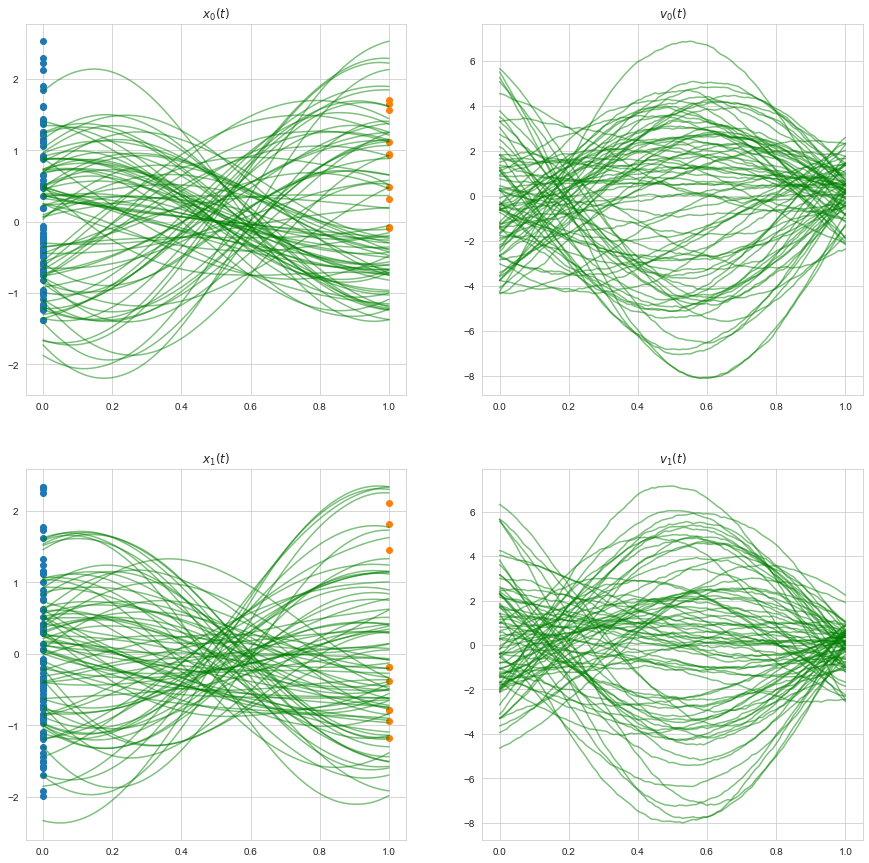

PLOT
haa


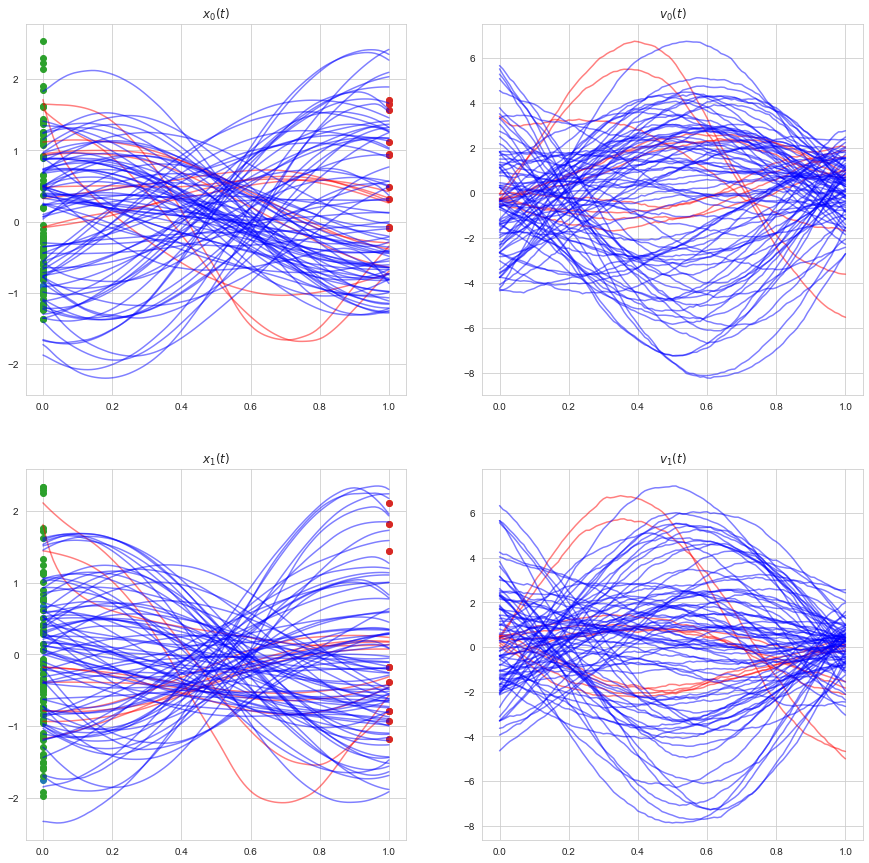

  0%|          | 0/20 [00:00<?, ?it/s]

haa


/Users/pierthodo/PycharmProjects/GP_Sinkhorn/gp_sinkhorn/GP.py:111: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, y[:, i], kernel, noise=torch.tensor(noise[i] / (dt)), mean_function=gp_mean_function_i
/Users/pierthodo/PycharmProjects/GP_Sinkhorn/gp_sinkhorn/GP.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, y[:, i], kernel, noise=torch.tensor(noise[i] / (dt)),precompute_inv=self.gpr_list[0].Kff_inv,
100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


PLOT
haa


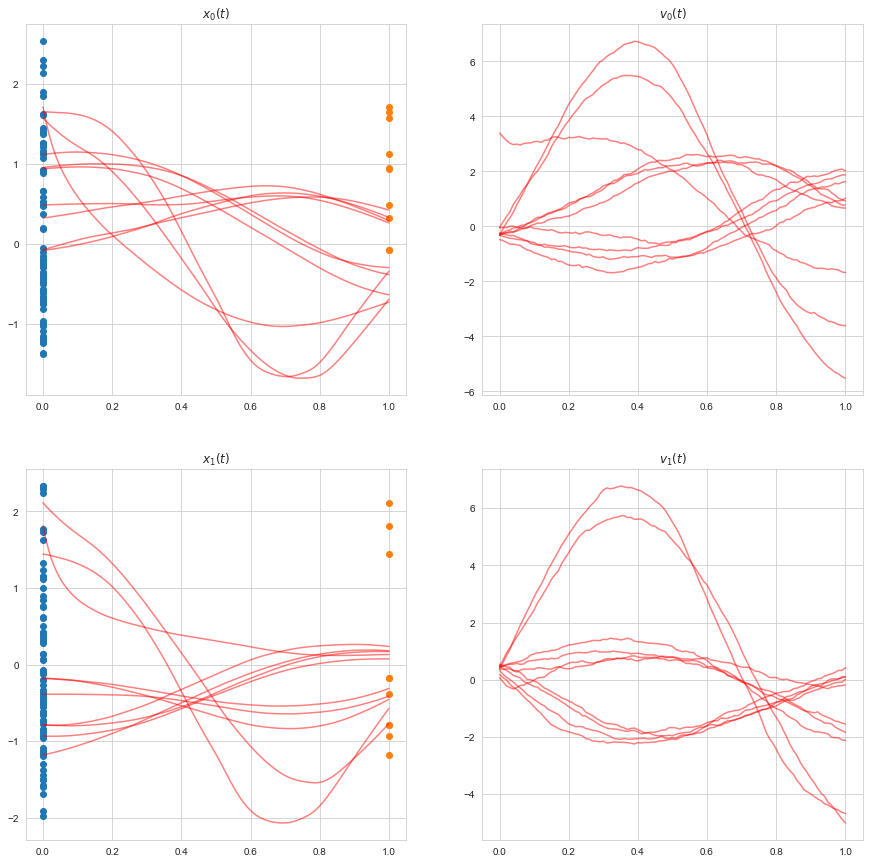

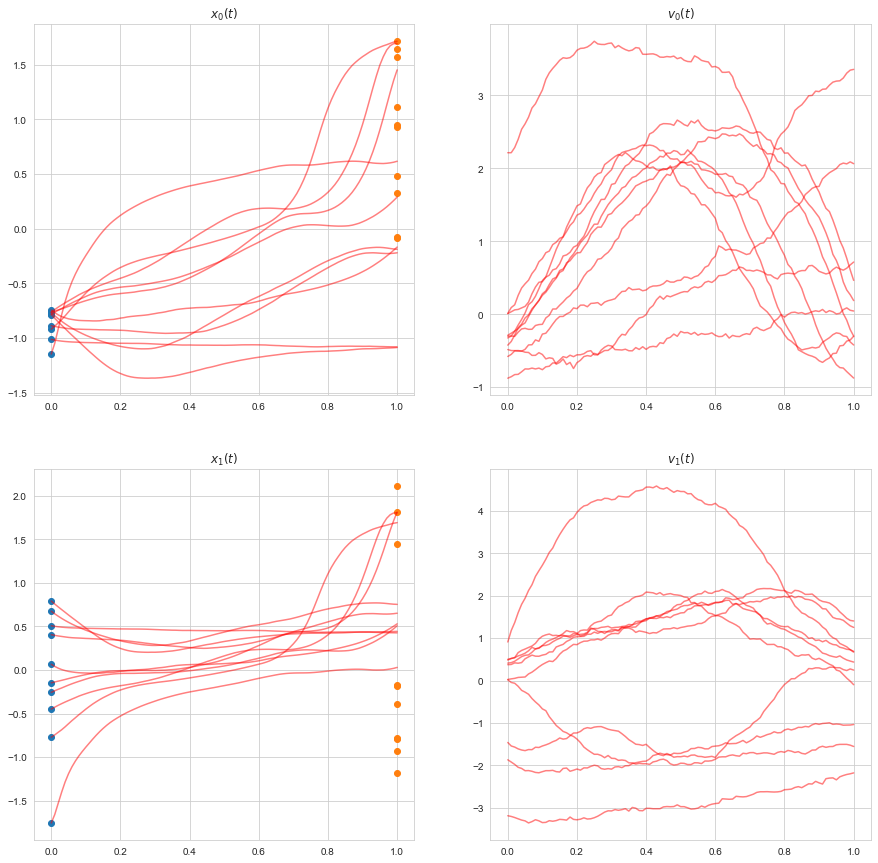

In [47]:
sigma_tt = torch.tensor(sigma_t)
sigma_tt[sigma_tt==0] =0.3
sigma_tt[sigma_tt==1] =0.3


print(sigma_tt)
prior_X_0=torch.cat((P_1,P_1))


num_samples_prior = 40
mu, std = P_0.mean(axis=0), torch.diag(P_0.std(axis=0))
prior_X_0_1 = torch.distributions.MultivariateNormal(mu.double().flatten(), std.double()).sample((num_samples_prior,))

mu2, std2 = P_1.mean(axis=0), torch.diag(P_1.std(axis=0))
prior_X_0_2 = torch.distributions.MultivariateNormal(mu2.double().flatten(), std2.double()).sample((num_samples_prior,))


prior_X_0f = torch.cat((prior_X_0_1,prior_X_0_2))




result = MLE_IPFP(
    P_0,P_1,
     N=N,prior_X_0=prior_X_0f,
    prior_drift=b_drift, iteration=20, sigma=(sigma_tt.flatten()),gp_mean_prior_flag=True, plot=True, langevin=True
)


In [48]:
prior_drift = None

result_1 = MLE_IPFP(
    P_0,P_1,N=N,sigma=0.3,
    prior_drift=None,#prior_Xts=prior_Xts,
    prior_X_0=None, iteration=10, refinement_iterations=0,
    decay_sigma=1, gp_mean_prior_flag=True
)


100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


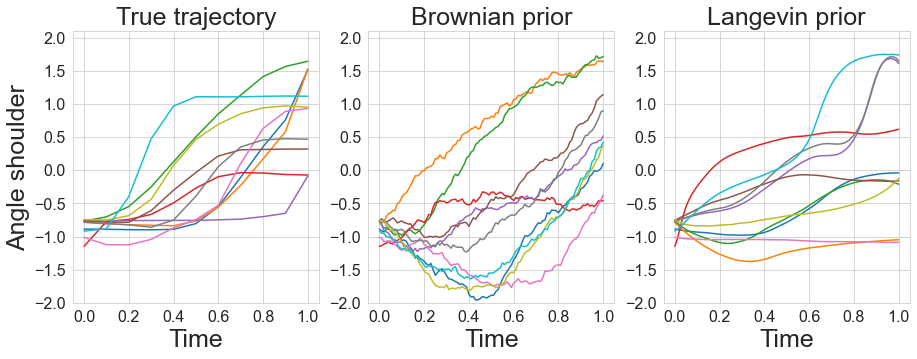

In [51]:
plt.figure(figsize=(15,5))
M = result_1[-1][1]
M_2 = result[-1][1]
fontsize=25
tick_size=16
n = 0
plt.subplot(1,3,2)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)

for i in range(M.shape[0]):
    plt.plot(M[i,:,-1],M[i,:,n])
    plt.title("Brownian prior", fontsize = fontsize)
    plt.ylim(-2,2.1)
    plt.xlabel("Time", fontsize = fontsize)

plt.subplot(1,3,3)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
for i in range(M.shape[0]):
    plt.plot(M_2[i,:,-1],M_2[i,:,n])
    plt.title("Langevin prior", fontsize = fontsize)
    plt.ylim(-2,2.1)
    plt.xlabel("Time", fontsize = fontsize)

plt.subplot(1,3,1)
plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
for i in range(M.shape[0]):
    plt.plot(np.arange(11)/10.0,traj[i,:,n])
    plt.title("True trajectory", fontsize = fontsize)
    plt.ylabel("Angle shoulder", fontsize = fontsize)
    plt.xlabel("Time", fontsize = fontsize)

    plt.ylim(-2,2.1)
"""
n = 1
plt.subplot(2,3,5)
for i in range(M.shape[0]):
    plt.plot(M[i,:,-1],M[i,:,n])
    plt.ylim(-3.5,2.7)

plt.subplot(2,3,6)
for i in range(M.shape[0]):
    plt.plot(M_2[i,:,-1],M_2[i,:,n])
    plt.ylim(-3.5,2.7)


plt.subplot(2,3,4)
for i in range(M.shape[0]):
    plt.plot(np.arange(11)/10.0,traj[i,:,n])
    plt.ylabel("Elbow", fontsize = fontsize)
    plt.ylim(-3.5,2.7)
"""
#plt.savefig('motion_traj_cut.pdf')  
#plt.tight_layout()
plt.show()
                